In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from torchvision.utils import save_image

import os
import numpy as np


torch.manual_seed(1)
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")


config = {
    "epoch":100,
    "batch_size":60,
    "LR":0.001,
    "DOWNLOAD_MNIST": False if os.path.exists('../mnist') else True,
    "N_TEST_IMG":5
}

In [2]:
'''
不需要 test data
'''
train_data = torchvision.datasets.MNIST(
    root='../mnist',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=config["DOWNLOAD_MNIST"],
)

data_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=config["batch_size"],
    shuffle=True
)



In [3]:
# AutoEncoder

class AutoEncoder(nn.Module):
    def __init__(self):
        
        super(AutoEncoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(
                in_features=28*28,
                out_features=128,
            ),
#             nn.Tanh(),
            nn.ReLU(),
            nn.Linear(
                in_features=128,
                out_features=64,
            ),
#             nn.Tanh(),
            nn.ReLU(),
            nn.Linear(
                in_features=64,
                out_features=12,
            ),
#             nn.Tanh(),
            nn.ReLU(),
            nn.Linear(
                in_features=12,
                out_features=3,
            ),
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(
                in_features=3,
                out_features=12,
            ),
#             nn.Tanh(),
            nn.ReLU(),
            nn.Linear(
                in_features=12,
                out_features=64,
            ),
#             nn.Tanh(),
            nn.ReLU(),
            nn.Linear(
                in_features=64,
                out_features=128,
            ),
#             nn.Tanh(),
            nn.ReLU(),
            nn.Linear(
                in_features=128,
                out_features=28*28,
            ),
            nn.Sigmoid(),  #因為原始資料為 0~1的數值
            
        )
        
        
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded,decoded

In [4]:
model = AutoEncoder().to(device)

print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [5]:
def draw_loss(loss_history):
    
    plt.plot(loss_history,label="loss",linewidth=1)
    plt.legend(loc='best')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.ylim((0, 4))
    plt.show()
    

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


    
def train(model,data_loader,view_data):
    l_h = []
    
    model.train()
    
    
    optimizer = optim.Adam(model.parameters(),lr=config['LR'])
    loss_fun = nn.MSELoss()
    
    for epoch in range(config["epoch"]):
        for step ,(b_x,b_label) in enumerate(data_loader):
            
            # x y 都是從 x 來
            b_x,b_y = b_x.view(-1,28*28).to(device) , b_x.view(-1,28*28).to(device)
            
            optimizer.zero_grad()
            
            encoded,decoded = model(b_x)
            
            loss = loss_fun(decoded,b_y)
            
            loss.backward()
            
            optimizer.step()
            
            l_h.append(loss.item())
            
            if step % 500 == 0:
                
                print('Epoch: ', epoch, '| step ',step,'| train loss: %.4f' % loss.item())
                
                pic = to_img(view_data.detach())
                save_image(pic, './img2/image_source.png')
                
                _, out = model(view_data.to(device))
                
                pic = to_img(out.cpu().detach())
                save_image(pic, './img2/image_{}_{}.png'.format(epoch,step))
    
    draw_loss(l_h)
            

Epoch:  0 | step  0 | train loss: 0.2326
Epoch:  0 | step  500 | train loss: 0.0529
Epoch:  1 | step  0 | train loss: 0.0424
Epoch:  1 | step  500 | train loss: 0.0468
Epoch:  2 | step  0 | train loss: 0.0417
Epoch:  2 | step  500 | train loss: 0.0408
Epoch:  3 | step  0 | train loss: 0.0371
Epoch:  3 | step  500 | train loss: 0.0370
Epoch:  4 | step  0 | train loss: 0.0362
Epoch:  4 | step  500 | train loss: 0.0335
Epoch:  5 | step  0 | train loss: 0.0333
Epoch:  5 | step  500 | train loss: 0.0341
Epoch:  6 | step  0 | train loss: 0.0338
Epoch:  6 | step  500 | train loss: 0.0346
Epoch:  7 | step  0 | train loss: 0.0307
Epoch:  7 | step  500 | train loss: 0.0351
Epoch:  8 | step  0 | train loss: 0.0352
Epoch:  8 | step  500 | train loss: 0.0315
Epoch:  9 | step  0 | train loss: 0.0337
Epoch:  9 | step  500 | train loss: 0.0340
Epoch:  10 | step  0 | train loss: 0.0354
Epoch:  10 | step  500 | train loss: 0.0360
Epoch:  11 | step  0 | train loss: 0.0324
Epoch:  11 | step  500 | train l

Epoch:  96 | step  0 | train loss: 0.0274
Epoch:  96 | step  500 | train loss: 0.0297
Epoch:  97 | step  0 | train loss: 0.0259
Epoch:  97 | step  500 | train loss: 0.0312
Epoch:  98 | step  0 | train loss: 0.0310
Epoch:  98 | step  500 | train loss: 0.0290
Epoch:  99 | step  0 | train loss: 0.0324
Epoch:  99 | step  500 | train loss: 0.0286


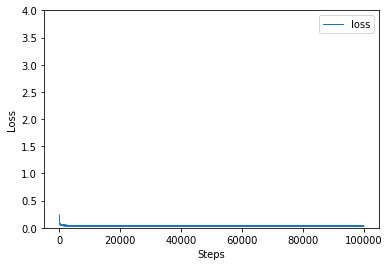

In [6]:
view_data = train_data.train_data[:config['N_TEST_IMG']].view(-1, 28*28).type(torch.FloatTensor)/255.

train(model,data_loader,view_data)

In [18]:

def test(model,test_data):
    model.eval()
    pic = to_img(test_data.detach())       
    save_image(pic, './img2/test_source.png')
                
    _, out = model(test_data.to(device))

    pic = to_img(out.cpu().detach())    
    save_image(pic, './img2/test.png')
    

        
test_data = train_data.train_data[-config['N_TEST_IMG']:].view(-1, 28*28).type(torch.FloatTensor)/255.        

test(model,test_data)